In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import pickle
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
os.listdir('../input/lish-moa')

['test_features.csv',
 'train_drug.csv',
 'train_features.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'sample_submission.csv']

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371


In [5]:
train_targets_scored.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_targets_nonscored.head(2)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_features.head(2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.151,-0.775
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.381,-0.730


In [8]:
sample_submission.head(2)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

## preprocess data

In [10]:
def drop_ctl_vehicle(train_features, test_features):
    
    train_features = train_features[train_features['cp_type'] != 'ctl_vehicle']
    test_features = test_features[test_features['cp_type'] != 'ctl_vehicle']
    target = train_targets_scored.iloc[train_features.index]
    train_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)
    
    return train_features, test_features, target

# train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
# test_features

In [11]:
def rank_gauss(train_features, test_features):
    
    train_features_ = train_features.copy()
    test_features_ = test_features.copy()
    
    GENES = [col for col in train_features_.columns if col.startswith('g-')]
    CELLS = [col for col in train_features_.columns if col.startswith('c-')]
    
    for col in (GENES + CELLS):

        transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
        vec_len = len(train_features_[col].values)
        vec_len_test = len(test_features_[col].values)
        raw_vec = train_features_[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)

        train_features_[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
        test_features_[col] = transformer.transform(test_features_[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
        
    return train_features_, test_features_

# train_features1, test_features1 = rank_gauss(train_features, test_features)
# train_features1

In [12]:
def get_stats(train_features, test_features):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    for df in [train_features, test_features]:
#         df['g_sum'] = df[GENES].sum(axis = 1)
        df['g_mean'] = df[GENES].mean(axis = 1)
        df['g_std'] = df[GENES].std(axis = 1)
        df['g_kurt'] = df[GENES].kurtosis(axis = 1)
        df['g_skew'] = df[GENES].skew(axis = 1)
#         df['g_max'] = df[GENES].max(axis=1)
#         df['g_min'] = df[GENES].max(axis=1)
#         df['c_sum'] = df[CELLS].sum(axis=1)
        df['c_mean'] = df[CELLS].mean(axis = 1)
        df['c_std'] = df[CELLS].std(axis = 1)
        df['c_kurt'] = df[CELLS].kurtosis(axis = 1)
        df['c_skew'] = df[CELLS].skew(axis = 1)
#         df['c_max'] = df[CELLS].max(axis=1)
#         df['c_min'] = df[CELLS].min(axis=1)
#         df['gc_sum'] = df[GENES + CELLS].sum(axis = 1)
        df['gc_mean'] = df[GENES + CELLS].mean(axis = 1)
        df['gc_std'] = df[GENES + CELLS].std(axis = 1)
        df['gc_kurt'] = df[GENES + CELLS].kurtosis(axis = 1)
        df['gc_skew'] = df[GENES + CELLS].skew(axis = 1)
        
    return train_features, test_features

# train_features, test_features = get_stats(train_features, test_features)
# test_features

In [13]:
def get_pca(train_features, test_features, n_gs, n_cs):
    
    GENES = [col for col in train_features.columns if col.startswith('g-')]
    CELLS = [col for col in train_features.columns if col.startswith('c-')]
    
    pca_gs = PCA(n_components = n_gs)
    pca_cs = PCA(n_components = n_cs)
    
    train_pca_gs = pca_gs.fit_transform(train_features[GENES])
    train_pca_cs = pca_cs.fit_transform(train_features[CELLS])
    test_pca_gs = pca_gs.transform(test_features[GENES])
    test_pca_cs = pca_cs.transform(test_features[CELLS])
    
    train_pca_gs = pd.DataFrame(train_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    train_pca_cs = pd.DataFrame(train_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    test_pca_gs = pd.DataFrame(test_pca_gs, columns=[f'pca_G-{i}' for i in range(n_gs)])
    test_pca_cs = pd.DataFrame(test_pca_cs, columns=[f'pca_C-{i}' for i in range(n_cs)])
    
    train_features = pd.concat([train_features, train_pca_gs, train_pca_cs], axis=1)
    test_features = pd.concat([test_features, test_pca_gs, test_pca_cs], axis=1)
    
    return train_features, test_features

# train_features, test_features = get_pca(train_features, test_features, n_gs=50, n_cs=15)
# test_features

In [14]:
def var_thresh(threshold, train_features, test_features):

    cols_numeric = [f for f in train_features.columns if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
    mask = (train_features[cols_numeric].var() >= 0.8).values
    train_features_ = train_features[cols_numeric].loc[:, mask]
    test_features_ = test_features[cols_numeric].loc[:, mask]
    train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1).reset_index(drop=True)
    test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1).reset_index(drop=True)

    return train_features, test_features

# train_features, test_features = var_thresh_2(threshold=0.2, train_features=train_features, test_features=test_features)
# test_features

In [15]:
def get_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 0):
    
    GENES = [col for col in train.columns if col.startswith('g-')]
    CELLS = [col for col in train.columns if col.startswith('c-')]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        
        return train, test
    
    train, test = create_cluster(train, test, GENES, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, CELLS, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

# train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)

In [16]:
def scaling(train_features, test_features):
    
    scaler = RobustScaler()
    train_features_ = train_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1)
    columns_ = train_features_.columns
    train_features_numerical = scaler.fit_transform(train_features_)
    test_features_numerical = scaler.transform(test_features.drop(['sig_id', 'cp_type', 'cp_time', 'cp_dose'], axis=1))
    train_features_ = pd.DataFrame(train_features_numerical)
    test_features_ = pd.DataFrame(test_features_numerical)
    train_features_ = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], train_features_], axis=1)
    test_features_ = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], test_features_], axis=1)
    
    return train_features_, test_features_

# train_features, test_features = scaling2(train_features, test_features)
# test_features

In [17]:
def make_folds(train, num_starts, num_splits):
    
    train_ = train.copy()
    folds = []

    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[(vc <= 6) | (vc == 12) | (vc == 18)].index.sort_values()
    vc2 = vc.loc[(vc > 6) & (vc != 12) & (vc != 18)].index.sort_values()

    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)

        del scored['fold']
        
        for i in range(len(folds)):
            train_[f'seed{i}'] = folds[i]

    return train_

In [18]:
def preprocessor(train_features, test_features):
    
#     # drop_ctl_vehicle
#     train_features, test_features, target = drop_ctl_vehicle(train_features, test_features)
    
    # rank_gauss
    train_features, test_features = rank_gauss(train_features, test_features)
    print('rank_gauss: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # stats
    train_features, test_features = get_stats(train_features, test_features)
    print('get_stats: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # pca
    train_features, test_features = get_pca(train_features, test_features, n_gs=600, n_cs=50) 
    print('get_pca: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
    # var_thresh
    train_features, test_features = var_thresh(threshold=0.8, train_features=train_features, test_features=test_features)
    print('var_thresh: done')
    print('train_features.shape', train_features.shape)
    print('test_features.shape', test_features.shape)
    
#     # clustering
#     train_features, test_features = get_cluster(train_features, test_features, n_clusters_g=35, n_clusters_c=5, SEED=0)
#     print('clustering: done')
#     print('train_features.shape', train_features.shape)
#     print('test_features.shape', test_features.shape)
    
#     # Scaling
#     train_features, test_features = scaling(train_features, test_features)
#     print('scaling: done')
    
    # data merge
    train = train_features.merge(train_targets_scored, on='sig_id')
    train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
    test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

    target = train[train_targets_scored.columns]
    
    train = train.drop('cp_type', axis=1)
    test = test.drop('cp_type', axis=1)
    
    return train, target, test  

train, target, test = preprocessor(train_features, test_features)

rank_gauss: done
train_features.shape (23814, 876)
test_features.shape (3982, 876)
get_stats: done
train_features.shape (23814, 888)
test_features.shape (3982, 888)
get_pca: done
train_features.shape (23814, 1538)
test_features.shape (3982, 1538)
var_thresh: done
train_features.shape (23814, 1044)
test_features.shape (3982, 1044)


In [19]:
folds = make_folds(train, num_starts=5, num_splits=5)

In [20]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
feature_cols = [c for c in pd.get_dummies(train, columns=['cp_time', 'cp_dose']).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]
len(feature_cols)

1045

In [21]:
folds

,sig_id,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,seed0,seed1,seed2,seed3,seed4
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,0,0,0,4,0,1,4,2
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,0,0,0,1,4,2,1,3
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,0,0,0,2,4,1,1,0
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,0,0,0,2,4,0,4,4
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,0,0,0,1,4,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.237856,-1.228203,0.218376,-0.365976,-0.330177,0.569243,-0.150978,...,0,0,0,0,0,0,1,2,3,3
21944,id_fffb1ceed,24,D2,0.209361,-0.022389,-0.235888,-0.796989,-0.674009,0.919312,0.735603,...,0,0,0,0,0,3,4,4,4,4
21945,id_fffb70c0c,24,D2,-1.911021,0.587228,-0.588417,1.296405,-1.002640,0.850589,-0.304313,...,0,0,0,0,0,1,4,4,1,2
21946,id_fffcb9e7c,24,D1,0.816407,0.417618,0.431631,0.300617,1.070346,-0.024189,0.048942,...,0,0,0,0,0,4,1,1,0,3


### shape check

In [22]:
print(f'train.shape: {train.shape}')
print(f'folds.shape: {folds.shape}')
print(f'test.shape: {test.shape}')
print(f'target.shape: {target.shape}')
print(f'sample_submission.shape: {sample_submission.shape}')

train.shape: (21948, 1249)
folds.shape: (21948, 1254)
test.shape: (3624, 1043)
target.shape: (21948, 207)
sample_submission.shape: (3982, 207)


### save data

In [23]:
all_data = {
    'train': train, 
    'folds': folds, 
    'test': test, 
    'target': target, 
    'sample_submission': sample_submission
}

In [24]:
with open('all_data_Simple.pickle', 'wb') as f:
    pickle.dump(all_data, f)

## Dataset Classes

In [25]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float), 
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### HyperParameters

In [26]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 35
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-6
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False
smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing

num_features = len(feature_cols)
num_targets = len(target_cols)
hidden_size_1 = 1024
hidden_size_2 = 1024

### Model

In [27]:
class Model_Simple(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size_1, hidden_size_2):
        super(Model_Simple, self).__init__()
        
        self.batch_norm1 = nn.BatchNorm1d(num_features=num_features)
#         self.dropout1 = nn.Dropout(0.1)
        self.Linear1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size_1))
        self.leaky_relu1 = nn.LeakyReLU()
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size_1)
        self.dropout2 = nn.Dropout(0.4)
        self.Linear2 = nn.utils.weight_norm(nn.Linear(hidden_size_1, hidden_size_2))
        self.leaky_relu2 = nn.LeakyReLU()
        
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size_2)
        self.dropout3 = nn.Dropout(0.4)
        self.Linear3 = nn.utils.weight_norm(nn.Linear(hidden_size_2, num_targets))
        
    def recalibrate_layer(self, layer):

        if(torch.isnan(layer.weight_v).sum() > 0):
            print ('recalibrate layer.weight_v')
            layer.weight_v = torch.nn.Parameter(torch.where(torch.isnan(layer.weight_v), torch.zeros_like(layer.weight_v), layer.weight_v))
            layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)

        if(torch.isnan(layer.weight).sum() > 0):
            print ('recalibrate layer.weight')
            layer.weight = torch.where(torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight)
            layer.weight += 1e-7
        
        
    def forward(self, x):
        x = self.batch_norm1(x)
#         x = self.dropout1(x)
        self.recalibrate_layer(self.Linear1)
        x = self.Linear1(x)
        x = self.leaky_relu1(x)
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        self.recalibrate_layer(layer=self.Linear2)
        x = self.Linear2(x)
        x = self.leaky_relu2(x)
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        self.recalibrate_layer(layer=self.Linear3)
        x = self.Linear3(x)
        
        return x

### training function

In [28]:
def train_fn(model, optimizer, scheduler, loss_tr, loss_fn, dataloader, device):
    rejected = 0
    model.train()
    final_loss = 0
    final_metric = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if len(inputs) > 1:
            outputs = model(inputs)
            loss = loss_tr(outputs, targets)
            metric = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            final_loss += loss.item()
            final_metric += metric.item()
        
        else:
            rejected += len(inputs)
            
        
    final_loss /= (len(dataloader) - rejected)
    final_metric /= (len(dataloader) - rejected)
    
    return final_loss, final_metric

In [29]:
def valid_fn(model, loss_tr, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    final_metric = 0
    valid_preds = []
    
    for data in dataloader:
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_tr(outputs, targets)
        metric = loss_fn(outputs, targets)
        final_loss += loss.item()
        final_metric += metric.item()
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)
        valid_preds.append(outputs.numpy())
        
    final_loss /= len(dataloader)
    final_metric /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
        
    return final_loss, final_metric, valid_preds

In [30]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            
        outputs = torch.clamp(torch.sigmoid(outputs).detach().cpu(), p_min, p_max)    
        preds.append(outputs.numpy())
        
    preds = np.concatenate(preds)
        
    return preds

### loss_function

In [31]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(DEVICE) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

In [32]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets
    
    def forward(self, inputs, targets):
            targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
                self.smoothing)
            loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

            if  self.reduction == 'sum':
                loss = loss.sum()
            elif  self.reduction == 'mean':
                loss = loss.mean()

            return loss

### Single fold training

In [33]:
def run_training(fold, seed, EPOCHS, LEARNING_RATE):
    
    print(f'==========FOLD{fold+1}==========')
    
    
    seed_everything(seed)
    
    train_losses = list()
    valid_losses = list()
    CV = list()
    
    train = pd.get_dummies(folds, columns=['cp_time', 'cp_dose'])
    test_ = pd.get_dummies(test, columns=['cp_time', 'cp_dose'])
    
    trn_idx = train[train[f'seed{seed}'] != fold].index
    val_idx = train[train[f'seed{seed}'] == fold].index
    
    train_df = train[train[f'seed{seed}'] != fold].reset_index()
    valid_df = train[train[f'seed{seed}'] == fold].reset_index()
    
    x_train, y_train = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid = valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_Simple(num_features=num_features,
                      num_targets=num_targets, 
                      hidden_size_1=hidden_size_1, 
                      hidden_size_2=hidden_size_2)
    

    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.3, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader)) 
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing=smoothing)
    
    early_stoppping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        print(f'-----EPOCH{epoch+1}-----')
        
        train_loss, train_metric = train_fn(model, optimizer, scheduler, loss_tr, loss_fn, trainloader, DEVICE)
        print(f'train_loss: {train_loss:.5f}, train_metric: {train_metric:.5f}')
        train_losses.append(train_metric)
        valid_loss, valid_metric, valid_preds = valid_fn(model, loss_tr, loss_fn, validloader, DEVICE)
        print(f'valid_loss: {valid_loss:.5f}, valid_metric: {valid_metric:.5f}')
        valid_losses.append(valid_metric)
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f'Simple_FOLD{fold+1}_SEED{seed}.pth')
            
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
                
    y_true = train_targets_scored[target_cols].values
                
    cv = 0
    for i in range(len(target_cols)):
        cv_ = log_loss(y_true[val_idx, i], oof[val_idx, i], labels=[0, 1])
        cv += cv_ / len(target_cols)
                
    plt.plot(train_losses, label='train_losses')
    plt.plot(valid_losses, label='valid_losses')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim([1e-2, 2e-2])
    plt.title(f'fold{fold+1} losses')
    plt.show()
                
    #-----------------------PREDICTION-------------------------
                
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_Simple(num_features=num_features, 
                             num_targets=num_targets, 
                             hidden_size_1=hidden_size_1,
                             hidden_size_2=hidden_size_2)
    
    model.load_state_dict(torch.load(f'Simple_FOLD{fold+1}_SEED{seed}.pth'))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions, cv

In [34]:
def run_k_fold(NFOLD, seed, EPOCH, LEARNING_RATE):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    CVs = list()
    
    for fold in range(NFOLDS):
        oof_, pred_, cv_ = run_training(fold, seed, EPOCH, LEARNING_RATE)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        CVs.append(cv_)
        
    return oof, predictions, CVs

device used: cuda
 
SEED : 0

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73635, train_metric: 0.73634
valid_loss: 0.64470, valid_metric: 0.64464
-----EPOCH2-----
train_loss: 0.26889, train_metric: 0.26795
valid_loss: 0.03480, valid_metric: 0.03276
-----EPOCH3-----
train_loss: 0.02799, train_metric: 0.02553
valid_loss: 0.02337, valid_metric: 0.02059
-----EPOCH4-----
train_loss: 0.02310, train_metric: 0.02017
valid_loss: 0.02175, valid_metric: 0.01872
-----EPOCH5-----
train_loss: 0.02204, train_metric: 0.01892
valid_loss: 0.02147, valid_metric: 0.01830
-----EPOCH6-----
train_loss: 0.02149, train_metric: 0.01828
valid_loss: 0.02110, valid_metric: 0.01790
-----EPOCH7-----
train_loss: 0.02067, train_metric: 0.01742
valid_loss: 0.02079, valid_metric: 0.01752
-----EPOCH8-----
train_loss: 0.02013, train_metric: 0.01689
valid_loss: 0.02063, valid_metric: 0.01741
-----EPOCH9-----
train_loss: 0.01995, train_metric: 0.01671
valid_loss: 0.02039, valid_metric: 0.01719
-----EPOCH10-----

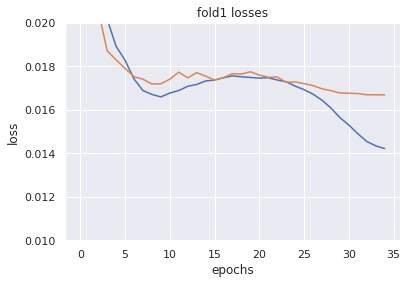

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73610, train_metric: 0.73609
valid_loss: 0.63760, valid_metric: 0.63753
-----EPOCH2-----
train_loss: 0.26850, train_metric: 0.26756
valid_loss: 0.03453, valid_metric: 0.03254
-----EPOCH3-----
train_loss: 0.02787, train_metric: 0.02543
valid_loss: 0.02457, valid_metric: 0.02192
-----EPOCH4-----
train_loss: 0.02318, train_metric: 0.02024
valid_loss: 0.02214, valid_metric: 0.01919
-----EPOCH5-----
train_loss: 0.02200, train_metric: 0.01887
valid_loss: 0.02184, valid_metric: 0.01868
-----EPOCH6-----
train_loss: 0.02117, train_metric: 0.01796
valid_loss: 0.02187, valid_metric: 0.01864
-----EPOCH7-----
train_loss: 0.02068, train_metric: 0.01742
valid_loss: 0.02168, valid_metric: 0.01842
-----EPOCH8-----
train_loss: 0.02017, train_metric: 0.01692
valid_loss: 0.02158, valid_metric: 0.01837
-----EPOCH9-----
train_loss: 0.01970, train_metric: 0.01646
valid_loss: 0.02130, valid_metric: 0.01809
-----EPOCH10-----
train_loss: 0.01970, train_me

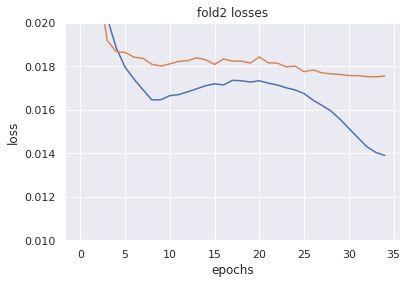

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73615, train_metric: 0.73614
valid_loss: 0.64586, valid_metric: 0.64580
-----EPOCH2-----
train_loss: 0.26921, train_metric: 0.26827
valid_loss: 0.03381, valid_metric: 0.03181
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02552
valid_loss: 0.02328, valid_metric: 0.02051
-----EPOCH4-----
train_loss: 0.02315, train_metric: 0.02020
valid_loss: 0.02150, valid_metric: 0.01849
-----EPOCH5-----
train_loss: 0.02202, train_metric: 0.01888
valid_loss: 0.02137, valid_metric: 0.01816
-----EPOCH6-----
train_loss: 0.02137, train_metric: 0.01815
valid_loss: 0.02127, valid_metric: 0.01799
-----EPOCH7-----
train_loss: 0.02058, train_metric: 0.01734
valid_loss: 0.02108, valid_metric: 0.01783
-----EPOCH8-----
train_loss: 0.02019, train_metric: 0.01695
valid_loss: 0.02092, valid_metric: 0.01765
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01665
valid_loss: 0.02086, valid_metric: 0.01768
-----EPOCH10-----
train_loss: 0.01977, train_me

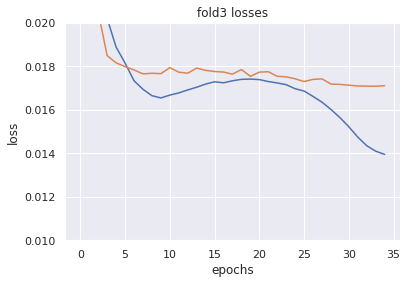

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73643, train_metric: 0.73642
valid_loss: 0.64886, valid_metric: 0.64881
-----EPOCH2-----
train_loss: 0.26971, train_metric: 0.26878
valid_loss: 0.03564, valid_metric: 0.03362
-----EPOCH3-----
train_loss: 0.02797, train_metric: 0.02551
valid_loss: 0.02384, valid_metric: 0.02106
-----EPOCH4-----
train_loss: 0.02302, train_metric: 0.02008
valid_loss: 0.02239, valid_metric: 0.01932
-----EPOCH5-----
train_loss: 0.02208, train_metric: 0.01894
valid_loss: 0.02166, valid_metric: 0.01848
-----EPOCH6-----
train_loss: 0.02130, train_metric: 0.01809
valid_loss: 0.02138, valid_metric: 0.01815
-----EPOCH7-----
train_loss: 0.02076, train_metric: 0.01751
valid_loss: 0.02113, valid_metric: 0.01790
-----EPOCH8-----
train_loss: 0.02017, train_metric: 0.01692
valid_loss: 0.02112, valid_metric: 0.01790
-----EPOCH9-----
train_loss: 0.01992, train_metric: 0.01668
valid_loss: 0.02086, valid_metric: 0.01763
-----EPOCH10-----
train_loss: 0.01982, train_me

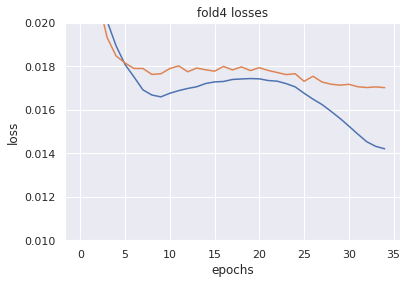

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73657, train_metric: 0.73656
valid_loss: 0.64389, valid_metric: 0.64383
-----EPOCH2-----
train_loss: 0.27087, train_metric: 0.26994
valid_loss: 0.03564, valid_metric: 0.03364
-----EPOCH3-----
train_loss: 0.02802, train_metric: 0.02557
valid_loss: 0.02325, valid_metric: 0.02049
-----EPOCH4-----
train_loss: 0.02303, train_metric: 0.02009
valid_loss: 0.02189, valid_metric: 0.01880
-----EPOCH5-----
train_loss: 0.02214, train_metric: 0.01899
valid_loss: 0.02162, valid_metric: 0.01844
-----EPOCH6-----
train_loss: 0.02147, train_metric: 0.01825
valid_loss: 0.02140, valid_metric: 0.01813
-----EPOCH7-----
train_loss: 0.02074, train_metric: 0.01750
valid_loss: 0.02109, valid_metric: 0.01780
-----EPOCH8-----
train_loss: 0.02021, train_metric: 0.01697
valid_loss: 0.02102, valid_metric: 0.01775
-----EPOCH9-----
train_loss: 0.01993, train_metric: 0.01669
valid_loss: 0.02104, valid_metric: 0.01787
-----EPOCH10-----
train_loss: 0.01982, train_me

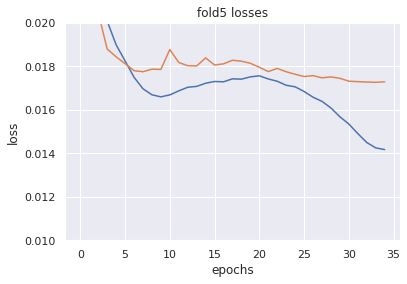

 
SEED : 1

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73628, train_metric: 0.73627
valid_loss: 0.64546, valid_metric: 0.64540
-----EPOCH2-----
train_loss: 0.26680, train_metric: 0.26586
valid_loss: 0.03513, valid_metric: 0.03312
-----EPOCH3-----
train_loss: 0.02809, train_metric: 0.02564
valid_loss: 0.02393, valid_metric: 0.02122
-----EPOCH4-----
train_loss: 0.02306, train_metric: 0.02013
valid_loss: 0.02244, valid_metric: 0.01927
-----EPOCH5-----
train_loss: 0.02243, train_metric: 0.01927
valid_loss: 0.02150, valid_metric: 0.01833
-----EPOCH6-----
train_loss: 0.02124, train_metric: 0.01801
valid_loss: 0.02111, valid_metric: 0.01791
-----EPOCH7-----
train_loss: 0.02066, train_metric: 0.01742
valid_loss: 0.02101, valid_metric: 0.01782
-----EPOCH8-----
train_loss: 0.02010, train_metric: 0.01686
valid_loss: 0.02092, valid_metric: 0.01765
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01666
valid_loss: 0.02096, valid_metric: 0.01773
-----EPOCH10-----
train_loss: 0.019

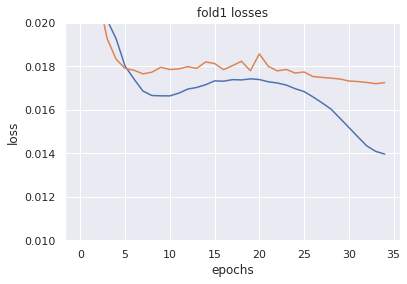

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73638, train_metric: 0.73637
valid_loss: 0.64382, valid_metric: 0.64376
-----EPOCH2-----
train_loss: 0.26910, train_metric: 0.26816
valid_loss: 0.03433, valid_metric: 0.03233
-----EPOCH3-----
train_loss: 0.02780, train_metric: 0.02535
valid_loss: 0.02349, valid_metric: 0.02074
-----EPOCH4-----
train_loss: 0.02291, train_metric: 0.01999
valid_loss: 0.02312, valid_metric: 0.02001
-----EPOCH5-----
train_loss: 0.02207, train_metric: 0.01894
valid_loss: 0.02167, valid_metric: 0.01850
-----EPOCH6-----
train_loss: 0.02109, train_metric: 0.01787
valid_loss: 0.02161, valid_metric: 0.01842
-----EPOCH7-----
train_loss: 0.02048, train_metric: 0.01723
valid_loss: 0.02109, valid_metric: 0.01785
-----EPOCH8-----
train_loss: 0.01995, train_metric: 0.01669
valid_loss: 0.02109, valid_metric: 0.01788
-----EPOCH9-----
train_loss: 0.01977, train_metric: 0.01654
valid_loss: 0.02138, valid_metric: 0.01813
-----EPOCH10-----
train_loss: 0.01978, train_me

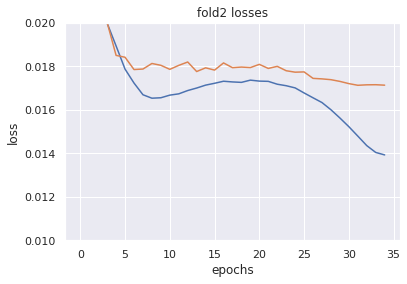

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73634, train_metric: 0.73633
valid_loss: 0.64228, valid_metric: 0.64222
-----EPOCH2-----
train_loss: 0.27168, train_metric: 0.27075
valid_loss: 0.03446, valid_metric: 0.03245
-----EPOCH3-----
train_loss: 0.02812, train_metric: 0.02567
valid_loss: 0.02390, valid_metric: 0.02112
-----EPOCH4-----
train_loss: 0.02323, train_metric: 0.02028
valid_loss: 0.02232, valid_metric: 0.01919
-----EPOCH5-----
train_loss: 0.02206, train_metric: 0.01891
valid_loss: 0.02171, valid_metric: 0.01846
-----EPOCH6-----
train_loss: 0.02114, train_metric: 0.01792
valid_loss: 0.02156, valid_metric: 0.01838
-----EPOCH7-----
train_loss: 0.02076, train_metric: 0.01750
valid_loss: 0.02150, valid_metric: 0.01822
-----EPOCH8-----
train_loss: 0.02010, train_metric: 0.01685
valid_loss: 0.02112, valid_metric: 0.01790
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01655
valid_loss: 0.02117, valid_metric: 0.01799
-----EPOCH10-----
train_loss: 0.01987, train_me

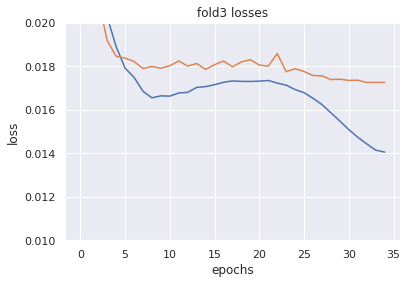

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73638, train_metric: 0.73636
valid_loss: 0.64182, valid_metric: 0.64175
-----EPOCH2-----
train_loss: 0.26880, train_metric: 0.26786
valid_loss: 0.03380, valid_metric: 0.03180
-----EPOCH3-----
train_loss: 0.02801, train_metric: 0.02557
valid_loss: 0.02278, valid_metric: 0.02003
-----EPOCH4-----
train_loss: 0.02334, train_metric: 0.02040
valid_loss: 0.02172, valid_metric: 0.01869
-----EPOCH5-----
train_loss: 0.02224, train_metric: 0.01911
valid_loss: 0.02155, valid_metric: 0.01836
-----EPOCH6-----
train_loss: 0.02143, train_metric: 0.01820
valid_loss: 0.02178, valid_metric: 0.01846
-----EPOCH7-----
train_loss: 0.02069, train_metric: 0.01744
valid_loss: 0.02135, valid_metric: 0.01810
-----EPOCH8-----
train_loss: 0.02024, train_metric: 0.01700
valid_loss: 0.02065, valid_metric: 0.01740
-----EPOCH9-----
train_loss: 0.01987, train_metric: 0.01663
valid_loss: 0.02083, valid_metric: 0.01759
-----EPOCH10-----
train_loss: 0.01990, train_me

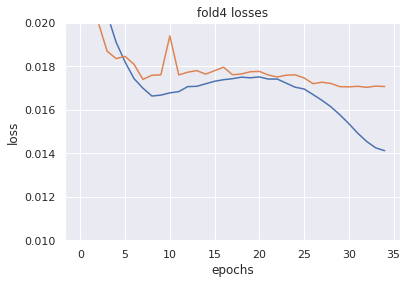

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73659, train_metric: 0.73658
valid_loss: 0.64626, valid_metric: 0.64620
-----EPOCH2-----
train_loss: 0.26748, train_metric: 0.26654
valid_loss: 0.03404, valid_metric: 0.03203
-----EPOCH3-----
train_loss: 0.02822, train_metric: 0.02577
valid_loss: 0.02347, valid_metric: 0.02068
-----EPOCH4-----
train_loss: 0.02332, train_metric: 0.02038
valid_loss: 0.02192, valid_metric: 0.01884
-----EPOCH5-----
train_loss: 0.02232, train_metric: 0.01918
valid_loss: 0.02145, valid_metric: 0.01831
-----EPOCH6-----
train_loss: 0.02145, train_metric: 0.01824
valid_loss: 0.02109, valid_metric: 0.01790
-----EPOCH7-----
train_loss: 0.02066, train_metric: 0.01742
valid_loss: 0.02076, valid_metric: 0.01749
-----EPOCH8-----
train_loss: 0.02019, train_metric: 0.01695
valid_loss: 0.02083, valid_metric: 0.01758
-----EPOCH9-----
train_loss: 0.01987, train_metric: 0.01664
valid_loss: 0.02070, valid_metric: 0.01744
-----EPOCH10-----
train_loss: 0.01991, train_me

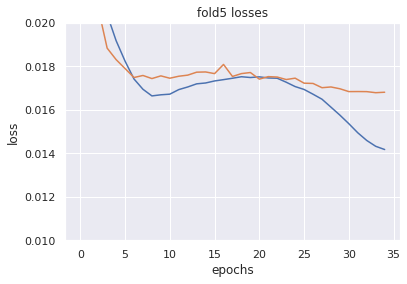

 
SEED : 2

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73468, train_metric: 0.73467
valid_loss: 0.64551, valid_metric: 0.64545
-----EPOCH2-----
train_loss: 0.27075, train_metric: 0.26981
valid_loss: 0.03437, valid_metric: 0.03233
-----EPOCH3-----
train_loss: 0.02811, train_metric: 0.02567
valid_loss: 0.02327, valid_metric: 0.02054
-----EPOCH4-----
train_loss: 0.02325, train_metric: 0.02031
valid_loss: 0.02157, valid_metric: 0.01852
-----EPOCH5-----
train_loss: 0.02252, train_metric: 0.01937
valid_loss: 0.02126, valid_metric: 0.01805
-----EPOCH6-----
train_loss: 0.02135, train_metric: 0.01813
valid_loss: 0.02144, valid_metric: 0.01820
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01747
valid_loss: 0.02087, valid_metric: 0.01763
-----EPOCH8-----
train_loss: 0.02030, train_metric: 0.01707
valid_loss: 0.02072, valid_metric: 0.01749
-----EPOCH9-----
train_loss: 0.01992, train_metric: 0.01669
valid_loss: 0.02068, valid_metric: 0.01743
-----EPOCH10-----
train_loss: 0.019

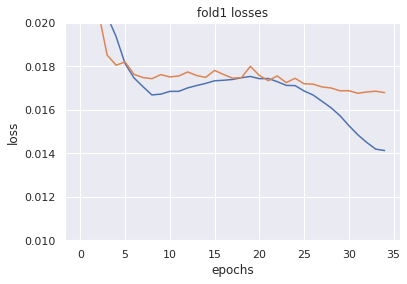

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73476, train_metric: 0.73474
valid_loss: 0.64400, valid_metric: 0.64394
-----EPOCH2-----
train_loss: 0.26621, train_metric: 0.26526
valid_loss: 0.03560, valid_metric: 0.03363
-----EPOCH3-----
train_loss: 0.02811, train_metric: 0.02566
valid_loss: 0.02350, valid_metric: 0.02077
-----EPOCH4-----
train_loss: 0.02319, train_metric: 0.02024
valid_loss: 0.02218, valid_metric: 0.01913
-----EPOCH5-----
train_loss: 0.02255, train_metric: 0.01939
valid_loss: 0.02212, valid_metric: 0.01889
-----EPOCH6-----
train_loss: 0.02166, train_metric: 0.01844
valid_loss: 0.02149, valid_metric: 0.01824
-----EPOCH7-----
train_loss: 0.02083, train_metric: 0.01758
valid_loss: 0.02146, valid_metric: 0.01819
-----EPOCH8-----
train_loss: 0.02021, train_metric: 0.01697
valid_loss: 0.02147, valid_metric: 0.01826
-----EPOCH9-----
train_loss: 0.01993, train_metric: 0.01669
valid_loss: 0.02122, valid_metric: 0.01803
-----EPOCH10-----
train_loss: 0.01989, train_me

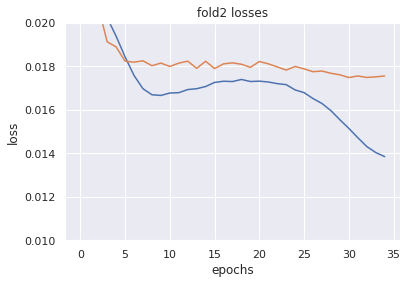

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73512, train_metric: 0.73511
valid_loss: 0.65039, valid_metric: 0.65033
-----EPOCH2-----
train_loss: 0.26952, train_metric: 0.26858
valid_loss: 0.03601, valid_metric: 0.03400
-----EPOCH3-----
train_loss: 0.02776, train_metric: 0.02530
valid_loss: 0.02354, valid_metric: 0.02076
-----EPOCH4-----
train_loss: 0.02300, train_metric: 0.02005
valid_loss: 0.02257, valid_metric: 0.01952
-----EPOCH5-----
train_loss: 0.02191, train_metric: 0.01879
valid_loss: 0.02218, valid_metric: 0.01899
-----EPOCH6-----
train_loss: 0.02156, train_metric: 0.01833
valid_loss: 0.02198, valid_metric: 0.01871
-----EPOCH7-----
train_loss: 0.02064, train_metric: 0.01739
valid_loss: 0.02126, valid_metric: 0.01802
-----EPOCH8-----
train_loss: 0.02014, train_metric: 0.01689
valid_loss: 0.02117, valid_metric: 0.01798
-----EPOCH9-----
train_loss: 0.01983, train_metric: 0.01660
valid_loss: 0.02147, valid_metric: 0.01831
-----EPOCH10-----
train_loss: 0.01980, train_me

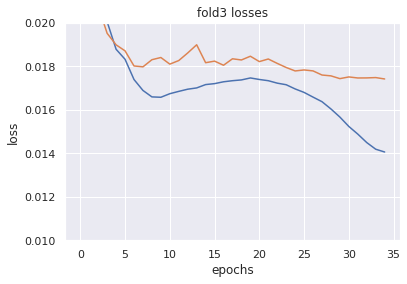

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73518, train_metric: 0.73516
valid_loss: 0.64787, valid_metric: 0.64782
-----EPOCH2-----
train_loss: 0.26974, train_metric: 0.26881
valid_loss: 0.03554, valid_metric: 0.03353
-----EPOCH3-----
train_loss: 0.02788, train_metric: 0.02543
valid_loss: 0.02315, valid_metric: 0.02040
-----EPOCH4-----
train_loss: 0.02324, train_metric: 0.02030
valid_loss: 0.02175, valid_metric: 0.01863
-----EPOCH5-----
train_loss: 0.02222, train_metric: 0.01909
valid_loss: 0.02146, valid_metric: 0.01826
-----EPOCH6-----
train_loss: 0.02142, train_metric: 0.01820
valid_loss: 0.02116, valid_metric: 0.01793
-----EPOCH7-----
train_loss: 0.02075, train_metric: 0.01751
valid_loss: 0.02081, valid_metric: 0.01759
-----EPOCH8-----
train_loss: 0.02014, train_metric: 0.01689
valid_loss: 0.02059, valid_metric: 0.01739
-----EPOCH9-----
train_loss: 0.01991, train_metric: 0.01667
valid_loss: 0.02070, valid_metric: 0.01751
-----EPOCH10-----
train_loss: 0.01992, train_me

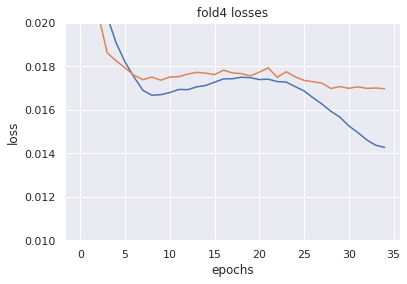

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73486, train_metric: 0.73485
valid_loss: 0.64355, valid_metric: 0.64349
-----EPOCH2-----
train_loss: 0.26940, train_metric: 0.26846
valid_loss: 0.03332, valid_metric: 0.03129
-----EPOCH3-----
train_loss: 0.02811, train_metric: 0.02566
valid_loss: 0.02290, valid_metric: 0.02015
-----EPOCH4-----
train_loss: 0.02316, train_metric: 0.02022
valid_loss: 0.02203, valid_metric: 0.01902
-----EPOCH5-----
train_loss: 0.02279, train_metric: 0.01963
valid_loss: 0.02190, valid_metric: 0.01865
-----EPOCH6-----
train_loss: 0.02151, train_metric: 0.01827
valid_loss: 0.02122, valid_metric: 0.01799
-----EPOCH7-----
train_loss: 0.02073, train_metric: 0.01749
valid_loss: 0.02089, valid_metric: 0.01765
-----EPOCH8-----
train_loss: 0.02028, train_metric: 0.01704
valid_loss: 0.02102, valid_metric: 0.01779
-----EPOCH9-----
train_loss: 0.02001, train_metric: 0.01677
valid_loss: 0.02088, valid_metric: 0.01766
-----EPOCH10-----
train_loss: 0.01991, train_me

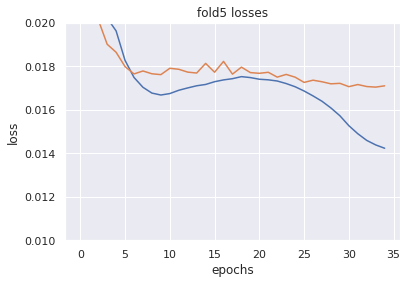

 
SEED : 3

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73550, train_metric: 0.73548
valid_loss: 0.64152, valid_metric: 0.64146
-----EPOCH2-----
train_loss: 0.26849, train_metric: 0.26755
valid_loss: 0.03569, valid_metric: 0.03371
-----EPOCH3-----
train_loss: 0.02820, train_metric: 0.02575
valid_loss: 0.02306, valid_metric: 0.02031
-----EPOCH4-----
train_loss: 0.02351, train_metric: 0.02055
valid_loss: 0.02146, valid_metric: 0.01842
-----EPOCH5-----
train_loss: 0.02205, train_metric: 0.01891
valid_loss: 0.02131, valid_metric: 0.01814
-----EPOCH6-----
train_loss: 0.02137, train_metric: 0.01814
valid_loss: 0.02117, valid_metric: 0.01790
-----EPOCH7-----
train_loss: 0.02075, train_metric: 0.01751
valid_loss: 0.02094, valid_metric: 0.01762
-----EPOCH8-----
train_loss: 0.02027, train_metric: 0.01703
valid_loss: 0.02087, valid_metric: 0.01758
-----EPOCH9-----
train_loss: 0.02001, train_metric: 0.01677
valid_loss: 0.02048, valid_metric: 0.01729
-----EPOCH10-----
train_loss: 0.019

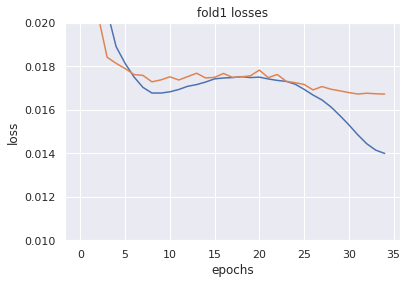

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73600, train_metric: 0.73599
valid_loss: 0.64719, valid_metric: 0.64714
-----EPOCH2-----
train_loss: 0.26830, train_metric: 0.26737
valid_loss: 0.03603, valid_metric: 0.03401
-----EPOCH3-----
train_loss: 0.02794, train_metric: 0.02549
valid_loss: 0.02414, valid_metric: 0.02139
-----EPOCH4-----
train_loss: 0.02314, train_metric: 0.02020
valid_loss: 0.02226, valid_metric: 0.01929
-----EPOCH5-----
train_loss: 0.02195, train_metric: 0.01883
valid_loss: 0.02161, valid_metric: 0.01843
-----EPOCH6-----
train_loss: 0.02139, train_metric: 0.01816
valid_loss: 0.02141, valid_metric: 0.01819
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01745
valid_loss: 0.02114, valid_metric: 0.01794
-----EPOCH8-----
train_loss: 0.02019, train_metric: 0.01695
valid_loss: 0.02119, valid_metric: 0.01795
-----EPOCH9-----
train_loss: 0.01984, train_metric: 0.01660
valid_loss: 0.02112, valid_metric: 0.01788
-----EPOCH10-----
train_loss: 0.01985, train_me

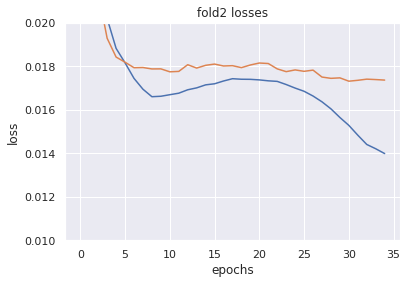

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73575, train_metric: 0.73574
valid_loss: 0.64473, valid_metric: 0.64467
-----EPOCH2-----
train_loss: 0.26957, train_metric: 0.26863
valid_loss: 0.03652, valid_metric: 0.03454
-----EPOCH3-----
train_loss: 0.02779, train_metric: 0.02533
valid_loss: 0.02342, valid_metric: 0.02061
-----EPOCH4-----
train_loss: 0.02308, train_metric: 0.02015
valid_loss: 0.02209, valid_metric: 0.01910
-----EPOCH5-----
train_loss: 0.02231, train_metric: 0.01917
valid_loss: 0.02217, valid_metric: 0.01883
-----EPOCH6-----
train_loss: 0.02151, train_metric: 0.01828
valid_loss: 0.02163, valid_metric: 0.01849
-----EPOCH7-----
train_loss: 0.02079, train_metric: 0.01755
valid_loss: 0.02127, valid_metric: 0.01805
-----EPOCH8-----
train_loss: 0.02036, train_metric: 0.01712
valid_loss: 0.02107, valid_metric: 0.01779
-----EPOCH9-----
train_loss: 0.01992, train_metric: 0.01668
valid_loss: 0.02103, valid_metric: 0.01785
-----EPOCH10-----
train_loss: 0.01980, train_me

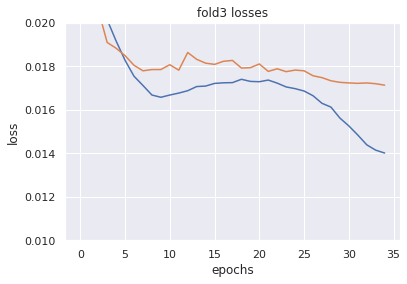

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73609, train_metric: 0.73608
valid_loss: 0.64427, valid_metric: 0.64421
-----EPOCH2-----
train_loss: 0.27118, train_metric: 0.27025
valid_loss: 0.03504, valid_metric: 0.03307
-----EPOCH3-----
train_loss: 0.02788, train_metric: 0.02544
valid_loss: 0.02368, valid_metric: 0.02093
-----EPOCH4-----
train_loss: 0.02319, train_metric: 0.02026
valid_loss: 0.02229, valid_metric: 0.01923
-----EPOCH5-----
train_loss: 0.02205, train_metric: 0.01891
valid_loss: 0.02175, valid_metric: 0.01856
-----EPOCH6-----
train_loss: 0.02136, train_metric: 0.01814
valid_loss: 0.02131, valid_metric: 0.01808
-----EPOCH7-----
train_loss: 0.02070, train_metric: 0.01745
valid_loss: 0.02113, valid_metric: 0.01790
-----EPOCH8-----
train_loss: 0.02007, train_metric: 0.01682
valid_loss: 0.02104, valid_metric: 0.01783
-----EPOCH9-----
train_loss: 0.01990, train_metric: 0.01667
valid_loss: 0.02115, valid_metric: 0.01801
-----EPOCH10-----
train_loss: 0.01984, train_me

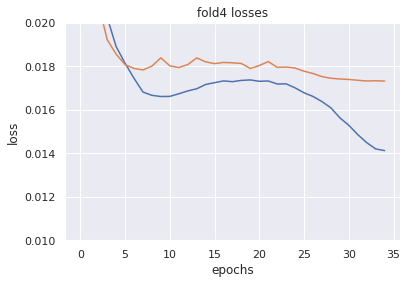

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73630, train_metric: 0.73629
valid_loss: 0.64295, valid_metric: 0.64289
-----EPOCH2-----
train_loss: 0.27135, train_metric: 0.27042
valid_loss: 0.03485, valid_metric: 0.03285
-----EPOCH3-----
train_loss: 0.02786, train_metric: 0.02540
valid_loss: 0.02309, valid_metric: 0.02035
-----EPOCH4-----
train_loss: 0.02287, train_metric: 0.01994
valid_loss: 0.02216, valid_metric: 0.01907
-----EPOCH5-----
train_loss: 0.02203, train_metric: 0.01889
valid_loss: 0.02137, valid_metric: 0.01821
-----EPOCH6-----
train_loss: 0.02127, train_metric: 0.01804
valid_loss: 0.02148, valid_metric: 0.01828
-----EPOCH7-----
train_loss: 0.02055, train_metric: 0.01730
valid_loss: 0.02100, valid_metric: 0.01779
-----EPOCH8-----
train_loss: 0.02007, train_metric: 0.01683
valid_loss: 0.02083, valid_metric: 0.01758
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01656
valid_loss: 0.02101, valid_metric: 0.01781
-----EPOCH10-----
train_loss: 0.01983, train_me

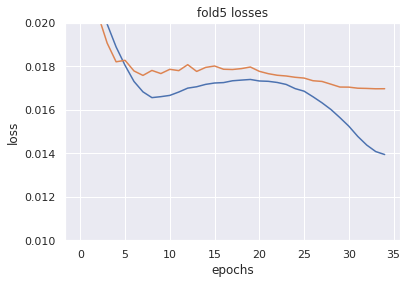

 
SEED : 4

==========FOLD1==========
-----EPOCH1-----
train_loss: 0.73678, train_metric: 0.73677
valid_loss: 0.64621, valid_metric: 0.64615
-----EPOCH2-----
train_loss: 0.27101, train_metric: 0.27007
valid_loss: 0.03397, valid_metric: 0.03198
-----EPOCH3-----
train_loss: 0.02840, train_metric: 0.02596
valid_loss: 0.02341, valid_metric: 0.02062
-----EPOCH4-----
train_loss: 0.02318, train_metric: 0.02023
valid_loss: 0.02233, valid_metric: 0.01930
-----EPOCH5-----
train_loss: 0.02218, train_metric: 0.01906
valid_loss: 0.02197, valid_metric: 0.01876
-----EPOCH6-----
train_loss: 0.02152, train_metric: 0.01831
valid_loss: 0.02110, valid_metric: 0.01787
-----EPOCH7-----
train_loss: 0.02090, train_metric: 0.01766
valid_loss: 0.02117, valid_metric: 0.01793
-----EPOCH8-----
train_loss: 0.02045, train_metric: 0.01722
valid_loss: 0.02099, valid_metric: 0.01774
-----EPOCH9-----
train_loss: 0.02001, train_metric: 0.01679
valid_loss: 0.02092, valid_metric: 0.01765
-----EPOCH10-----
train_loss: 0.019

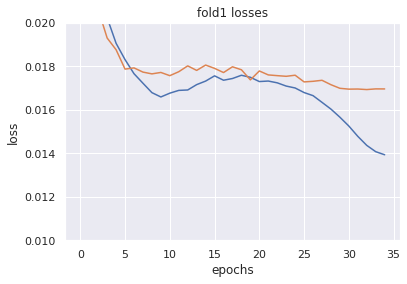

==========FOLD2==========
-----EPOCH1-----
train_loss: 0.73682, train_metric: 0.73681
valid_loss: 0.64784, valid_metric: 0.64778
-----EPOCH2-----
train_loss: 0.27101, train_metric: 0.27008
valid_loss: 0.03445, valid_metric: 0.03243
-----EPOCH3-----
train_loss: 0.02824, train_metric: 0.02580
valid_loss: 0.02343, valid_metric: 0.02074
-----EPOCH4-----
train_loss: 0.02331, train_metric: 0.02037
valid_loss: 0.02158, valid_metric: 0.01853
-----EPOCH5-----
train_loss: 0.02231, train_metric: 0.01917
valid_loss: 0.02156, valid_metric: 0.01830
-----EPOCH6-----
train_loss: 0.02156, train_metric: 0.01833
valid_loss: 0.02102, valid_metric: 0.01786
-----EPOCH7-----
train_loss: 0.02066, train_metric: 0.01741
valid_loss: 0.02103, valid_metric: 0.01780
-----EPOCH8-----
train_loss: 0.02022, train_metric: 0.01697
valid_loss: 0.02069, valid_metric: 0.01747
-----EPOCH9-----
train_loss: 0.01989, train_metric: 0.01664
valid_loss: 0.02073, valid_metric: 0.01754
-----EPOCH10-----
train_loss: 0.01990, train_me

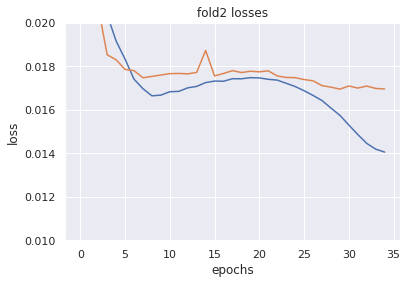

==========FOLD3==========
-----EPOCH1-----
train_loss: 0.73732, train_metric: 0.73731
valid_loss: 0.64567, valid_metric: 0.64561
-----EPOCH2-----
train_loss: 0.27143, train_metric: 0.27050
valid_loss: 0.03403, valid_metric: 0.03203
-----EPOCH3-----
train_loss: 0.02802, train_metric: 0.02557
valid_loss: 0.02345, valid_metric: 0.02070
-----EPOCH4-----
train_loss: 0.02306, train_metric: 0.02014
valid_loss: 0.02194, valid_metric: 0.01899
-----EPOCH5-----
train_loss: 0.02214, train_metric: 0.01902
valid_loss: 0.02188, valid_metric: 0.01868
-----EPOCH6-----
train_loss: 0.02144, train_metric: 0.01821
valid_loss: 0.02127, valid_metric: 0.01808
-----EPOCH7-----
train_loss: 0.02074, train_metric: 0.01751
valid_loss: 0.02106, valid_metric: 0.01779
-----EPOCH8-----
train_loss: 0.02007, train_metric: 0.01683
valid_loss: 0.02099, valid_metric: 0.01779
-----EPOCH9-----
train_loss: 0.01981, train_metric: 0.01657
valid_loss: 0.02105, valid_metric: 0.01785
-----EPOCH10-----
train_loss: 0.01981, train_me

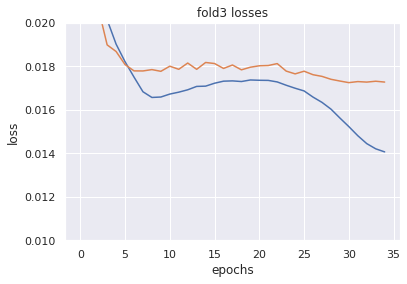

==========FOLD4==========
-----EPOCH1-----
train_loss: 0.73754, train_metric: 0.73753
valid_loss: 0.64928, valid_metric: 0.64923
-----EPOCH2-----
train_loss: 0.27296, train_metric: 0.27203
valid_loss: 0.03465, valid_metric: 0.03267
-----EPOCH3-----
train_loss: 0.02816, train_metric: 0.02571
valid_loss: 0.02311, valid_metric: 0.02036
-----EPOCH4-----
train_loss: 0.02303, train_metric: 0.02010
valid_loss: 0.02249, valid_metric: 0.01930
-----EPOCH5-----
train_loss: 0.02232, train_metric: 0.01918
valid_loss: 0.02141, valid_metric: 0.01824
-----EPOCH6-----
train_loss: 0.02124, train_metric: 0.01802
valid_loss: 0.02134, valid_metric: 0.01814
-----EPOCH7-----
train_loss: 0.02058, train_metric: 0.01735
valid_loss: 0.02092, valid_metric: 0.01771
-----EPOCH8-----
train_loss: 0.02012, train_metric: 0.01688
valid_loss: 0.02092, valid_metric: 0.01773
-----EPOCH9-----
train_loss: 0.01982, train_metric: 0.01659
valid_loss: 0.02071, valid_metric: 0.01751
-----EPOCH10-----
train_loss: 0.01973, train_me

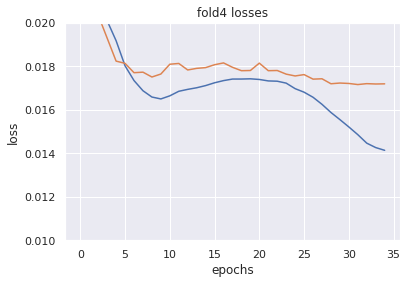

==========FOLD5==========
-----EPOCH1-----
train_loss: 0.73718, train_metric: 0.73717
valid_loss: 0.64046, valid_metric: 0.64040
-----EPOCH2-----
train_loss: 0.26906, train_metric: 0.26812
valid_loss: 0.03349, valid_metric: 0.03148
-----EPOCH3-----
train_loss: 0.02780, train_metric: 0.02537
valid_loss: 0.02461, valid_metric: 0.02186
-----EPOCH4-----
train_loss: 0.02312, train_metric: 0.02018
valid_loss: 0.02225, valid_metric: 0.01923
-----EPOCH5-----
train_loss: 0.02200, train_metric: 0.01887
valid_loss: 0.02192, valid_metric: 0.01870
-----EPOCH6-----
train_loss: 0.02141, train_metric: 0.01818
valid_loss: 0.02197, valid_metric: 0.01875
-----EPOCH7-----
train_loss: 0.02054, train_metric: 0.01729
valid_loss: 0.02127, valid_metric: 0.01806
-----EPOCH8-----
train_loss: 0.02004, train_metric: 0.01679
valid_loss: 0.02142, valid_metric: 0.01818
-----EPOCH9-----
train_loss: 0.01980, train_metric: 0.01656
valid_loss: 0.02119, valid_metric: 0.01800
-----EPOCH10-----
train_loss: 0.01971, train_me

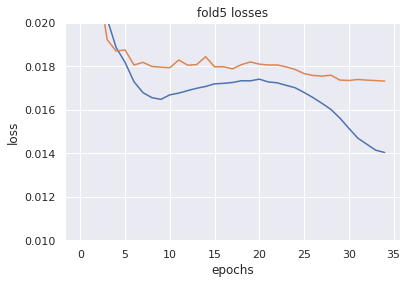

In [35]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3, 4]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))
CVs = list()

print(f'device used: {DEVICE}')

for seed in SEED:
    
    print(f' ')
    print(f'SEED : {seed}')
    print(f'')
    
    oof_, predictions_, CVs_ = run_k_fold(NFOLDS, seed, EPOCHS, LEARNING_RATE)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)
    CVs += CVs_
    
train[target_cols] = oof
test[target_cols] = predictions

In [36]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(
    train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

cv = 0
# cv_indivisual = list()
for i in range(len(target_cols)):
    cv_ = log_loss(y_true[:, i], y_pred[:, i])
#     cv_indivisual.append(cv_)
    cv += cv_ / len(target_cols)
    
auc = 0
for i in range(len(target_cols)):
    auc_ = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc += auc_ / len(target_cols)
    
print(f'CV log_loss: {cv:.6f} +/- {np.std(CVs):.6f}')
print(f'AUC: {auc:.6f}')

CV log_loss: 0.015573 +/- 0.000283
AUC: 0.673310


In [37]:
file_path = 'oof_Simple.npy'
np.save(file_path, oof)

sub = sample_submission.drop(columns=target_cols).merge(
    test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [38]:
print(f'sample_submission.shape : {sample_submission.shape}')
print(f'sub.shape : {sub.shape}')

sample_submission.shape : (3982, 207)
sub.shape : (3982, 207)
